In [ ]:
import pandas as pd
import torch as torch
import numpy as np
from scipy.stats import zscore
from torch.utils.data import DataLoader,Dataset, TensorDataset, random_split
import math
import torchvision.datasets as datasets 
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the minst dataset using pandas
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None) 
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [ ]:
# no. of classes, features, and samples
n_classes = 10
n_features = 28*28

In [ ]:
x_training = full_train_dataset.data.numpy().reshape(-1,n_features).astype(dtype=np.float)/255.0
y_train_cat = full_train_dataset.targets

x_testing = full_test_dataset.data.numpy().reshape(-1,n_features).astype(dtype=np.float)/255.0 
y_test_cat = full_test_dataset.targets

In [ ]:
y_train = pd.get_dummies(y_train_cat).to_numpy()
y_test = pd.get_dummies(y_test_cat).to_numpy()

In [ ]:
x_train = x_training
x_test = x_testing

In [ ]:
# convert data and labels into tensors
t_x_train=torch.tensor(x_train,requires_grad=False,device=device)
t_y_train=torch.tensor(y_train,requires_grad=False,device=device)

t_x_test=torch.tensor(x_test,requires_grad=False,device=device)
t_y_test=torch.tensor(y_test,requires_grad=False,device=device)

In [ ]:
# combain data and labels into a tensor dataset
train_dataset = TensorDataset(t_x_train, t_y_train)
test_dataset = TensorDataset(t_x_test, t_y_test)

In [ ]:
#creats data loader for training data
batch_size=2000
dL_train = DataLoader(train_dataset, batch_size= batch_size,shuffle=True)
dL_test = DataLoader(test_dataset,batch_size=t_y_test.shape[0])

In [ ]:
#define starting value of weights W for gradient descent
# W = n_features* n_classes
init_std_dev = 0.001;
initialW=init_std_dev*np.random.randn(n_features,n_classes)

In [ ]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [ ]:
# create a PyTorch tensor variable for W and b. 
# we will be optimizing over W, b, finding their best value using gradient descent,so we need gradient enabled
W = torch.tensor(initialW,requires_grad=True,device=device);
# the shape of b = 1*n_classes
b = torch.zeros((1,n_classes),requires_grad=True,device=device);

In [ ]:
# this optimizer will do gradient descent for us
learning_rate = 0.001;
optimizer = torch.optim.SGD([W,b],lr=learning_rate)
#optimizer = torch.optim.Adam([W,b],lr=learning_rate)

In [ ]:
n_epochs = 1000
loss = []
t_accuracy = []
for i in range(n_epochs):
  accuracy = 0
  batches = 0
  training_loss = 0
  for j ,data in enumerate(dL_train):
    batches +=1 
    inputs,labels = data
    # clear previous gradient calculations
    optimizer.zero_grad();
    # calculate model predictions
    linear_predictions = torch.matmul(inputs,W)+b
    #map prediction outputs into specific valuse using that sum to one (softmax function)
    activations = softmax(linear_predictions)
    #calculate loss(using cross entropy)
    prediction_error = -torch.sum(torch.multiply(labels,torch.log(activations)),axis=1)
    risk =torch.mean(prediction_error)
    training_loss+=risk.item()
    #calculate gradients of risk w.r.t. W,b and propagate them back
    risk.backward();
    # use the gradient to change W, b
    optimizer.step()
    # calculate accuracy (on the training set!)
    true_class = np.argmax(labels.detach().cpu().numpy(),axis=1)
    pred_class = np.argmax(activations.detach().cpu().numpy(),axis=1)
    accuracy += np.count_nonzero(true_class == pred_class)/pred_class.shape[0];
    error = 1.0 - accuracy;
  loss.append(training_loss/batches)
  t_accuracy.append(accuracy/batches)
  print('Epoch: [{:}/{:}]\t\t loss: {:.3f}\t accuracy: {:.3f}'.format(i+1,n_epochs,training_loss/batches,accuracy/batches))

Epoch: [1/1000]		 loss: 2.287	 accuracy: 0.390
Epoch: [2/1000]		 loss: 2.256	 accuracy: 0.607
Epoch: [3/1000]		 loss: 2.225	 accuracy: 0.662
Epoch: [4/1000]		 loss: 2.195	 accuracy: 0.682
Epoch: [5/1000]		 loss: 2.166	 accuracy: 0.697
Epoch: [6/1000]		 loss: 2.137	 accuracy: 0.707
Epoch: [7/1000]		 loss: 2.109	 accuracy: 0.713
Epoch: [8/1000]		 loss: 2.082	 accuracy: 0.721
Epoch: [9/1000]		 loss: 2.056	 accuracy: 0.725
Epoch: [10/1000]		 loss: 2.030	 accuracy: 0.730
Epoch: [11/1000]		 loss: 2.004	 accuracy: 0.734
Epoch: [12/1000]		 loss: 1.979	 accuracy: 0.736
Epoch: [13/1000]		 loss: 1.955	 accuracy: 0.739
Epoch: [14/1000]		 loss: 1.931	 accuracy: 0.742
Epoch: [15/1000]		 loss: 1.908	 accuracy: 0.744
Epoch: [16/1000]		 loss: 1.885	 accuracy: 0.747
Epoch: [17/1000]		 loss: 1.863	 accuracy: 0.749
Epoch: [18/1000]		 loss: 1.842	 accuracy: 0.751
Epoch: [19/1000]		 loss: 1.820	 accuracy: 0.753
Epoch: [20/1000]		 loss: 1.800	 accuracy: 0.755
Epoch: [21/1000]		 loss: 1.779	 accuracy: 0.756
E

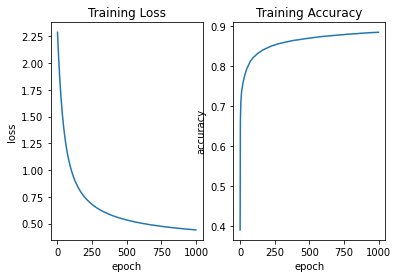

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(loss,'-')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(t_accuracy)
plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()



In [ ]:
#test the model using testing dataset
for k ,data in enumerate(dL_test):
    inputs,labels = data
    # calculate model predictions
    linear_predictions = torch.matmul(inputs,W)+b
    #map prediction outputs into specific valuse using that sum to one (softmax function)
    activations = softmax(linear_predictions)
    
    #calculate loss(using cross entropy)
    prediction_error = -torch.sum(torch.multiply(labels,torch.log(activations)),axis = 1)
    risk =torch.mean(prediction_error)
    
    # calculate accuracy (on the training set!)
    true_class = np.argmax(labels.detach().cpu().numpy(),axis=1)
    pred_class = np.argmax(activations.detach().cpu().numpy(),axis=1)
    accuracy = np.count_nonzero(true_class == pred_class)/pred_class.shape[0];
    error = 1.0 - accuracy;
    print('loss: {:.3f}\t accuracy: {:.3f}'.format(risk.item(),accuracy))

loss: 0.419	 accuracy: 0.893


#HW2.4 Report:
The code has been experminted using different parameters such as: learning_rate, epoches and init_std_dev. In each expement same parameter setup is applied for both optimizers(Adam and SGD) to see how each optimizer acts. The results was collected and compaierd for analysis purpose. The following is some observations from the results:

# Observations:
1. Adam needs smaller learning rate to work properly.
2. SGD shows more stability over all experiments combared to Adam. 
3. Adam reaches minimum values faster than SGD.However, choosing the parameters is critical since Adam can result in overflow with the wrong parameters. 
4. 0.001 learning rate and init_std_dev shows best results when using Adam optimizer. 
5. SGD works better with smaller batch sizes while Adam prefer larger batch sizes. 
